In [0]:
import json
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from src.vit.transforms import get_transforms
from src.vit.data import load_galaxy10
from src.vit.models import get_model
from datasets import load_dataset

In [0]:
dataset = load_dataset("matthieulel/galaxy10_decals")["test"]

/databricks/python_shell/lib/dbruntime/huggingface_patches/datasets.py:55: UserWarning: The cache_dir for this dataset is /tmp/.hf.data.cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [UC Volumes].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/Volumes/']
  warnings.warn(warning_message)
/databricks/python_shell/lib/dbruntime/huggingface_patches/datasets.py:24: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


In [0]:
def plot_attention(config_path, checkpoint_path):
    config = json.load(open(config_path, 'r'))
    _, test_tf = get_transforms(config)
    model = get_model(checkpoint_path)
    model.eval()

    img_idx = [0, 2, 4, 5]

    imgs = [dataset[i]['image'] for i in img_idx]
    labels = [dataset[i]['label'] for i in img_idx]
    tensor_imgs = [test_tf(img) for img in imgs]
    batch = torch.stack(tensor_imgs)

    outputs = model(batch, output_attentions=True)
    logits = outputs.logits.argmax(dim=1)
    attentions = outputs.attentions

    for idx in range(batch.size(0)):
        # atención de la última capa para esta imagen
        att = attentions[-1][idx]   # (num_heads, tokens, tokens)

        # Promedio entre heads
        att = att.mean(dim=0)       # (tokens, tokens)

        cls_att = att[0, 1:]        # CLS hacia patches

        map_att = cls_att.reshape(14, 14).detach().cpu().numpy()
        map_att = (map_att - map_att.min()) / (map_att.max() - map_att.min())

        img = imgs[idx]   # PIL
        att_resized = cv2.resize(map_att, (img.size[0], img.size[1]))
        att_color = cv2.applyColorMap((att_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
        att_overlay = cv2.addWeighted(np.array(img), 0.6, att_color, 0.4, 0)

        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.title(f"Original (clase: {labels[idx]})")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(att_overlay)
        plt.title(f"Attention Overlay (clase predicha: {logits[idx]})")
        plt.axis("off")
        plt.show()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-b617066c-0952-4895-9b40-afcadd8bab95/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-b617066c-0952-4895-9b40-afcadd8bab95/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


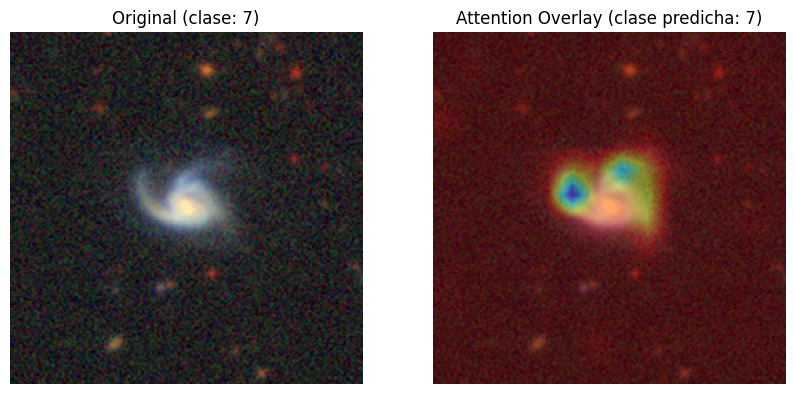

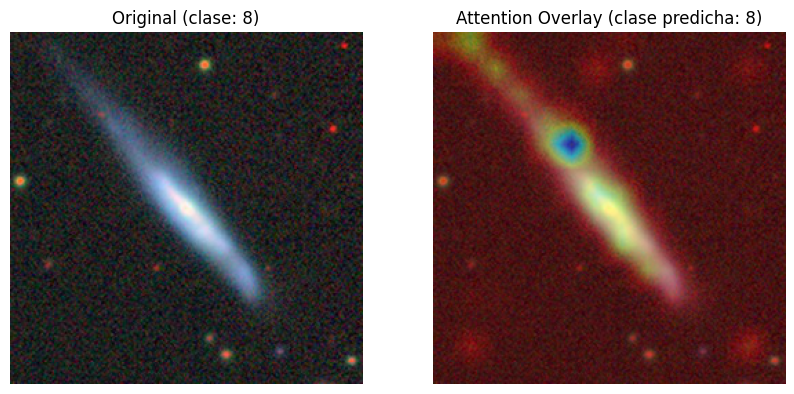

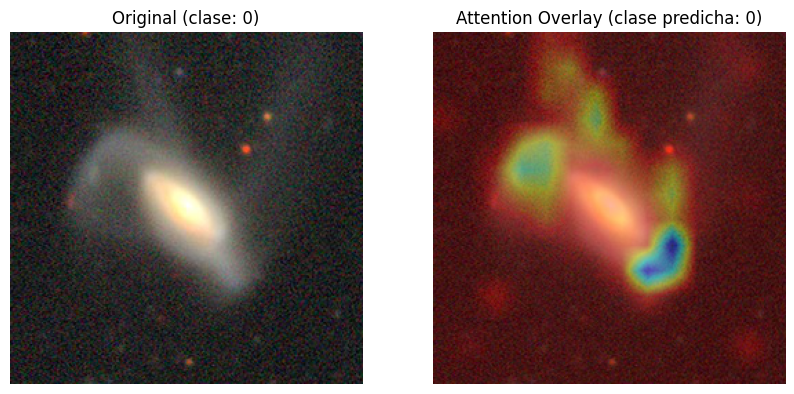

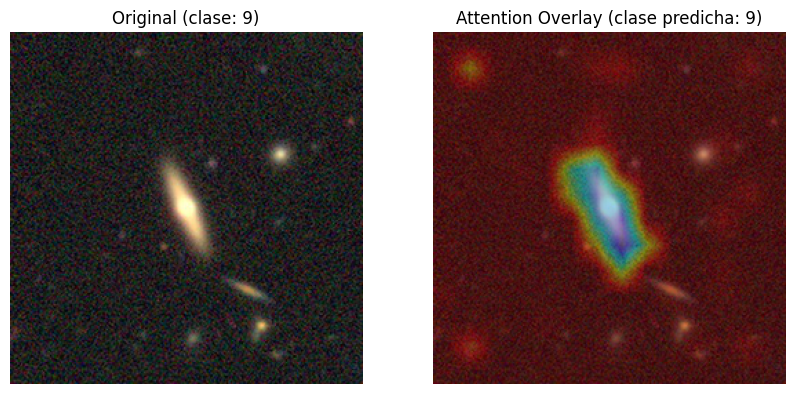

In [0]:
plot_attention(
    "/Workspace/Users/kevincajachuan@gmail.com/vpc3/configs/deit-small/config.json",
    "/Workspace/Users/kevincajachuan@gmail.com/vpc3/checkpoints/facebook-deit-small-patch16-224/checkpoint-7984"
)